This notebook creates a dataset from your scrobbles and then gives you your top 10 genres for all time.

*I should point out that the notebook uses artist's top tags not really genres.*

Enter your API key and username in the cell below. ⬇

In [ ]:
import requests, json, time, pandas as pd
key = 'your api key on last.fm'
username = 'your username on last.fm'

The functions below make 2 requests. The first one gets artist top tags. And the second one gets all of your scrobbles.

In [ ]:
def get_artist_tags(artist, key=key, autocorrect=1):
  '''
  artist: artist name
  key: your api key
  '''
  # url request
  url = 'http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={}&api_key={}&format=json'
  # list to store all responses
  responses = []
  # list to store genres of artist music
  tags = []

  # make request
  request_url = url.format(artist, key, autocorrect)
  responses.append(requests.get(request_url))

  for response in responses:
    scrobbles = response.json()
    if 'artist' in scrobbles:
      for scrobble in scrobbles['artist']['tags']['tag']:
        # 'seen live' is last.fm tag for artist that most users have seen live, we don't need it
        if scrobble['name']!='seen live' and scrobble['name']!='russian':
          tags.append(scrobble['name']) 

  return tuple(tags)

In [ ]:
# how long to pause between API requests
pause_duration = 0.2

In [ ]:
def get_scrobbles(method='recenttracks', username=username, key=key, limit=200, extended=0, page=1, pages=0):
    '''
    method: api method
    username: your last.fm username
    key: your last.fm api key
    limit: api lets you retrieve up to 200 records per call
    extended: api lets you retrieve extended data for each track, 0=no, 1=yes
    page: page of results to start retrieving at
    pages: how many pages of results to retrieve. if 0, get as many as api can return.
    '''
    # initialize url and lists to contain response fields
    url = 'https://ws.audioscrobbler.com/2.0/?method=user.get{}&user={}&api_key={}&limit={}&extended={}&page={}&format=json'
    responses = []
    artist_names = []
    album_names = []
    track_names = []
    timestamps = []
    tags = []
    
    # make the first request to get the total number of pages
    request_url = url.format(method, username, key, limit, extended, page)
    response = requests.get(request_url).json()
    total_pages = int(response[method]['@attr']['totalPages'])
    if pages > 0:
        total_pages = min([total_pages, pages])
    
    # request each page of data one at a time
    for page in range(1, int(total_pages) + 1, 1):
        if page % 10 == 0: print(page, end=' ')
        time.sleep(pause_duration)
        request_url = url.format(method, username, key, limit, extended, page)
        responses.append(requests.get(request_url))
    
    # parse the fields out of each scrobble in each page of scrobbles
    for response in responses:
        scrobbles = response.json()
        for scrobble in scrobbles[method]['track']:
            if 'date' in scrobble.keys():
                artist_names.append(scrobble['artist']['#text'].replace(' & ', '&'))
                album_names.append(scrobble['album']['#text'])
                track_names.append(scrobble['name'].replace(' & ', '&'))
                timestamps.append(scrobble['date']['uts'])
                tags.append(get_artist_tags(scrobble['artist']['#text'].replace(' & ', '&')))
                
    # create a dataframe to store the dataset
    df = pd.DataFrame()
    df['artist'] = artist_names
    df['album'] = album_names
    df['track'] = track_names
    df['timestamp'] = timestamps
    df['datetime'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
    df['tags'] = tags
    
    return df

In [ ]:
# get dataset, it might take time
scrobbles = get_scrobbles(pages=0)

In [ ]:
# how the dataset looks like
scrobbles.head()

,artist,album,track,timestamp,datetime,tags
0,KSLV Noh,Override,Override,1658060586,2022-07-17 12:23:06,"(phonk, Lo-Fi, memphis, drift phonk)"
1,PHOROMANE,KILLASTORE,KILLASTORE,1658060515,2022-07-17 12:21:55,()
2,Ghostemane,PLAGUES,Andromeda,1658060392,2022-07-17 12:19:52,"(cloud rap, Hip-Hop, rap, Horrorcore, Trap Metal)"
3,$uicideboy$,YUNGDEATHLILLIFE,GLOSS OF BLOOD,1658060285,2022-07-17 12:18:05,"(cloud rap, Hip-Hop, trap, rap, Horrorcore)"
4,Skidz,massacre,massacre,1658060170,2022-07-17 12:16:10,()


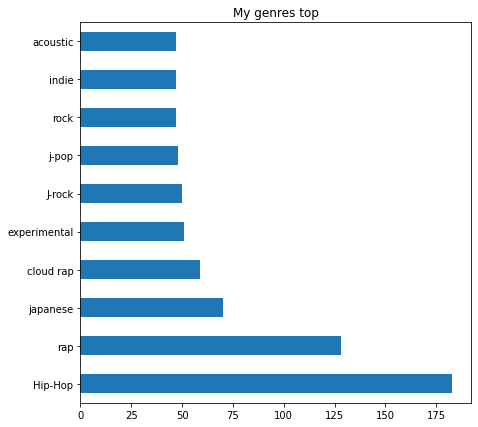

In [ ]:
# show your top 10 genres
scrobbles['tags'].explode('tags').dropna().value_counts().head(10).plot(
    kind='barh', figsize=(7,7), title='My genres top')